In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import joblib
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import files
uploaded = files.upload()


Saving heart.csv to heart.csv


In [13]:
DATA_PATH = "heart.csv"
RANDOM_STATE = 42
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [14]:
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (1025, 14)
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


In [15]:
print("\nMissing values:\n", df.isnull().sum())
print("\nColumn types:\n", df.dtypes)



Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Column types:
 age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


In [18]:

TARGET = 'target'
if TARGET not in df.columns:

    for alt in ['target', 'HeartDisease', 'output', 'condition']:
        if alt in df.columns:
            TARGET = alt
            break
    else:
        raise ValueError("Target column not found. Update TARGET variable to your dataset's target column name.")

In [17]:
X = df.drop(columns=[TARGET])
y = df[TARGET].copy()


cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
if X[num_cols].isnull().any().any():
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())

feature_names = X.columns.tolist()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")



Train shape: (820, 13), Test shape: (205, 13)


In [20]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1] if hasattr(dt, "predict_proba") else None

def print_metrics(y_true, y_pred, y_proba=None, model_name="Model"):
    print(f"\n=== {model_name} performance ===")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred, zero_division=0), 4))
    print("Recall:", round(recall_score(y_true, y_pred, zero_division=0), 4))
    print("F1-score:", round(f1_score(y_true, y_pred, zero_division=0), 4))
    if y_proba is not None:
        try:
            print("ROC-AUC:", round(roc_auc_score(y_true, y_proba), 4))
        except Exception:
            pass
    print("\nClassification report:\n", classification_report(y_true, y_pred))

print_metrics(y_test, y_pred_dt, y_proba_dt, "Decision Tree (default)")


=== Decision Tree (default) performance ===
Accuracy: 0.9854
Precision: 1.0
Recall: 0.9714
F1-score: 0.9855
ROC-AUC: 0.9857

Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



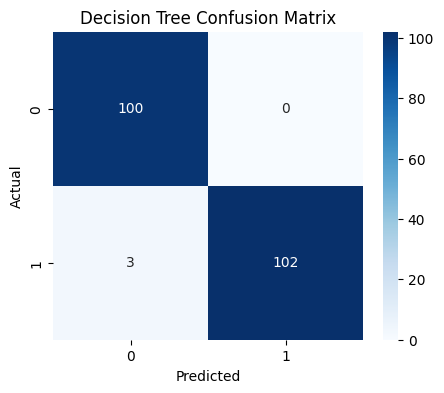

In [21]:
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


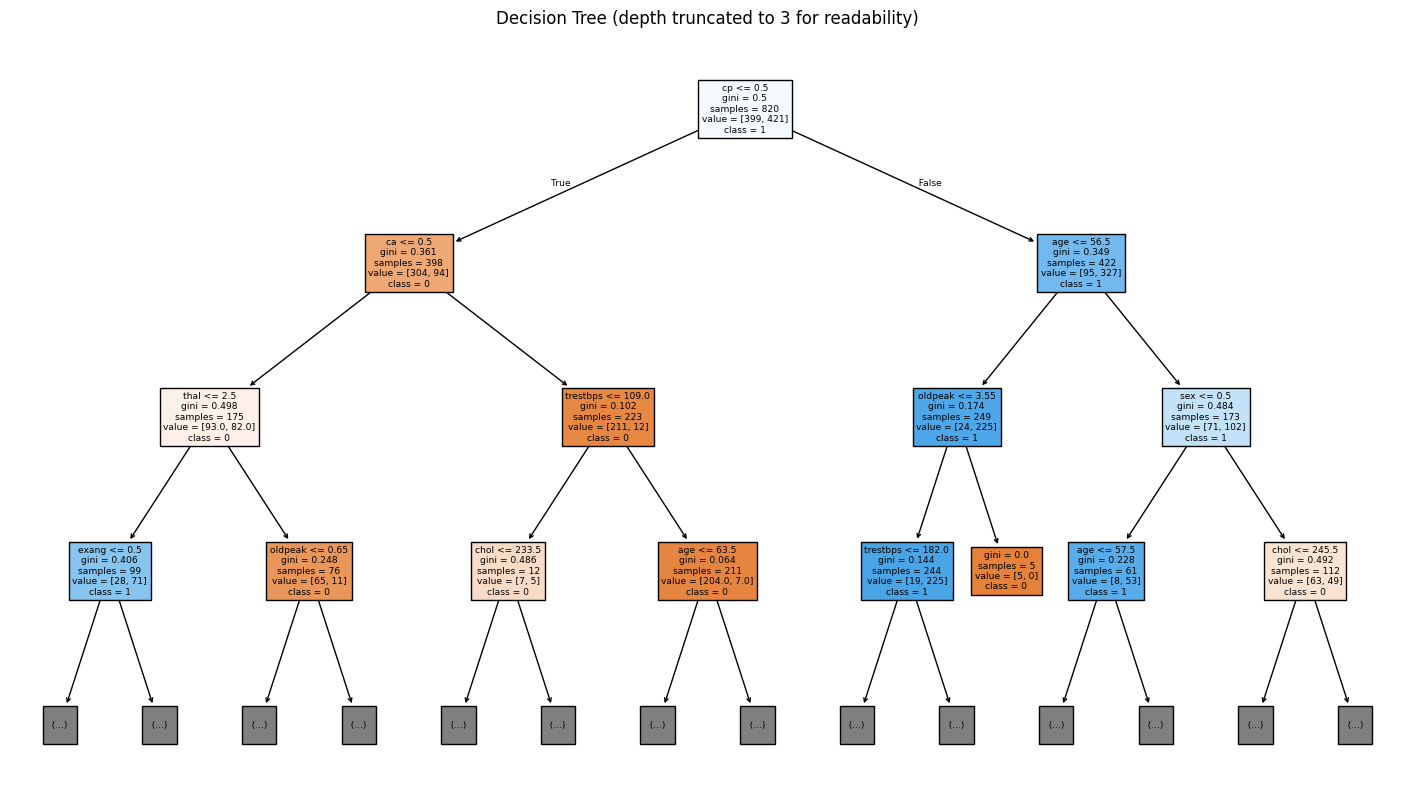

In [22]:
plt.figure(figsize=(18,10))
plot_tree(dt, feature_names=feature_names, class_names=[str(c) for c in dt.classes_], filled=True, max_depth=3)
plt.title("Decision Tree (depth truncated to 3 for readability)")
plt.show()


Top features (Decision Tree):
 cp          0.299922
ca          0.128631
age         0.114920
chol        0.099451
thal        0.079146
oldpeak     0.054481
trestbps    0.051820
thalach     0.043466
slope       0.038558
sex         0.035869
dtype: float64


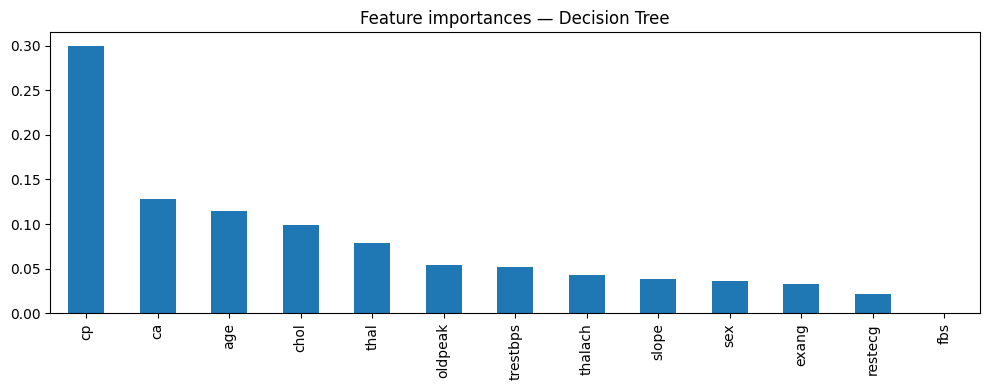

In [23]:
fi_dt = pd.Series(dt.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nTop features (Decision Tree):\n", fi_dt.head(10))
fi_dt.head(15).plot(kind='bar', figsize=(10,4))
plt.title('Feature importances — Decision Tree')
plt.tight_layout()
plt.show()


In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores_dt = cross_val_score(dt, X, y, cv=cv, scoring='accuracy')
print("CV accuracy (Decision Tree):", cv_scores_dt, "mean:", cv_scores_dt.mean())

CV accuracy (Decision Tree): [1. 1. 1. 1. 1.] mean: 1.0


In [26]:
param_grid_dt = {
    'max_depth': [2, 3, 4, 5, 6, None],
    'min_samples_split': [2, 5, 10, 20]
}
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid_dt,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
grid_dt.fit(X_train, y_train)
print("\nBest Decision Tree params:", grid_dt.best_params_)
best_dt = grid_dt.best_estimator_


Best Decision Tree params: {'max_depth': None, 'min_samples_split': 2}


In [27]:
y_pred_best_dt = best_dt.predict(X_test)
y_proba_best_dt = best_dt.predict_proba(X_test)[:,1] if hasattr(best_dt, "predict_proba") else None
print_metrics(y_test, y_pred_best_dt, y_proba_best_dt, "Decision Tree (tuned)")


=== Decision Tree (tuned) performance ===
Accuracy: 0.9854
Precision: 1.0
Recall: 0.9714
F1-score: 0.9855
ROC-AUC: 0.9857

Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



In [28]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print_metrics(y_test, y_pred_rf, y_proba_rf, "Random Forest (default)")


=== Random Forest (default) performance ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205




Top features (Random Forest):
 cp          0.142094
thalach     0.117349
ca          0.114844
oldpeak     0.112634
thal        0.095930
age         0.091285
chol        0.077771
exang       0.073707
trestbps    0.067765
slope       0.048711
dtype: float64


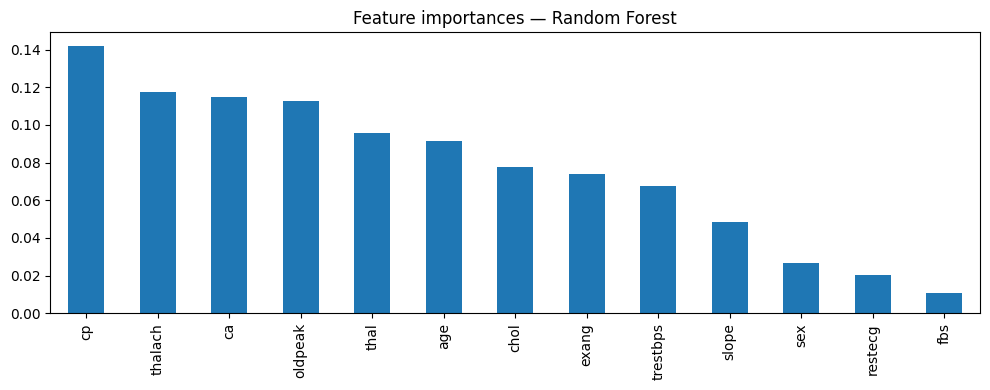

In [29]:
fi_rf = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print("\nTop features (Random Forest):\n", fi_rf.head(10))
fi_rf.head(15).plot(kind='bar', figsize=(10,4))
plt.title('Feature importances — Random Forest')
plt.tight_layout()
plt.show()

In [30]:
cv_scores_rf = cross_val_score(rf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print("CV accuracy (Random Forest):", cv_scores_rf, "mean:", cv_scores_rf.mean())

CV accuracy (Random Forest): [1.        1.        1.        0.9804878 1.       ] mean: 0.9960975609756098


In [31]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
print("\nBest Random Forest params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)
y_proba_best_rf = best_rf.predict_proba(X_test)[:,1]

print_metrics(y_test, y_pred_best_rf, y_proba_best_rf, "Random Forest (tuned)")


Best Random Forest params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

=== Random Forest (tuned) performance ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



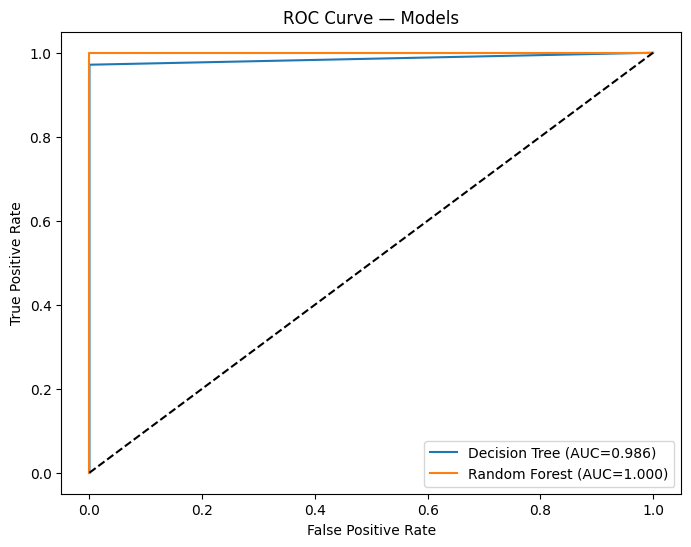

In [32]:
# -------------------------
plt.figure(figsize=(8,6))
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_best_dt) if y_proba_best_dt is not None else (None,None,None)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_best_rf)

if fpr_dt is not None:
    plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={roc_auc_score(y_test, y_proba_best_dt):.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={roc_auc_score(y_test, y_proba_best_rf):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Models")
plt.legend()
plt.show()

In [33]:

joblib.dump(best_dt, os.path.join(MODEL_DIR, "best_decision_tree.joblib"))
joblib.dump(best_rf, os.path.join(MODEL_DIR, "best_random_forest.joblib"))
print(f"Saved models to {MODEL_DIR}/")

Saved models to models/


In [34]:
# -------------------------
print("\nSummary:")
print(f"Decision Tree (tuned) accuracy: {accuracy_score(y_test, y_pred_best_dt):.4f}")
print(f"Random Forest (tuned) accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")



Summary:
Decision Tree (tuned) accuracy: 0.9854
Random Forest (tuned) accuracy: 1.0000


In [35]:
fi_combined = pd.DataFrame({
    'feature': feature_names,
    'importance_decision_tree': best_dt.feature_importances_,
    'importance_random_forest': best_rf.feature_importances_
}).sort_values(by='importance_random_forest', ascending=False)
fi_combined.to_csv(os.path.join(MODEL_DIR, "feature_importances_comparison.csv"), index=False)
print("Feature importances saved.")

Feature importances saved.
